In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from pathlib import Path
import configparser

font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)


In [2]:
class hashableDict(dict):
    def __hash__(self):
        return hash(tuple(sorted(self.items())))

In [3]:
results_path = '../results'
scaling_test = 'inference-colocated-scaling'
run_path = 'run-2023-05-23-16:49:05'
full_path = Path(results_path, scaling_test, run_path)

configs = []

functions = ['put_tensor', 'run_script', 'run_model', 'unpack_tensor']

for run_cfg in full_path.rglob('run.cfg'):
    config = configparser.ConfigParser()
    config.read(run_cfg)
    configs.append(config)

df_list = []

for config in configs:
    timing_files = Path(config['run']['path']).glob('rank*.csv')
    df_config_list = []
    for timing_file in timing_files:
        tmp_df = pd.read_csv(timing_file, header=0, names=["rank", "function", "time"])
        for key, value in config._sections['attributes'].items():
            tmp_df[key] = value
        df_list.append(tmp_df)

df = pd.concat(df_list, ignore_index=True)

    
    

In [4]:
df

,rank,function,time,colocated,pin_app_cpus,client_total,client_per_node,client_nodes,database_nodes,database_cpus,database_threads_per_queue,batch_size,device,num_devices,language
0,1,put_tensor,0.006156,1,1,36,36,1,1,12,2,96,GPU,1,cpp
1,1,run_script,0.006582,1,1,36,36,1,1,12,2,96,GPU,1,cpp
2,1,run_model,0.020233,1,1,36,36,1,1,12,2,96,GPU,1,cpp
3,1,unpack_tensor,0.000182,1,1,36,36,1,1,12,2,96,GPU,1,cpp
4,1,put_tensor,0.008101,1,1,36,36,1,1,12,2,96,GPU,1,cpp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183079,7,run_script,0.007817,1,1,24,24,1,1,12,2,96,GPU,1,cpp
183080,7,run_model,0.009311,1,1,24,24,1,1,12,2,96,GPU,1,cpp
183081,7,unpack_tensor,0.000047,1,1,24,24,1,1,12,2,96,GPU,1,cpp
183082,7,loop_time,2.380580,1,1,24,24,1,1,12,2,96,GPU,1,cpp


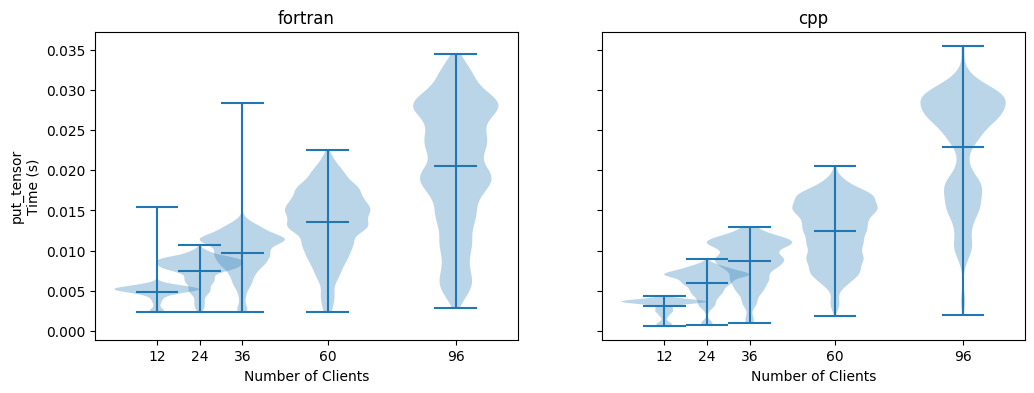

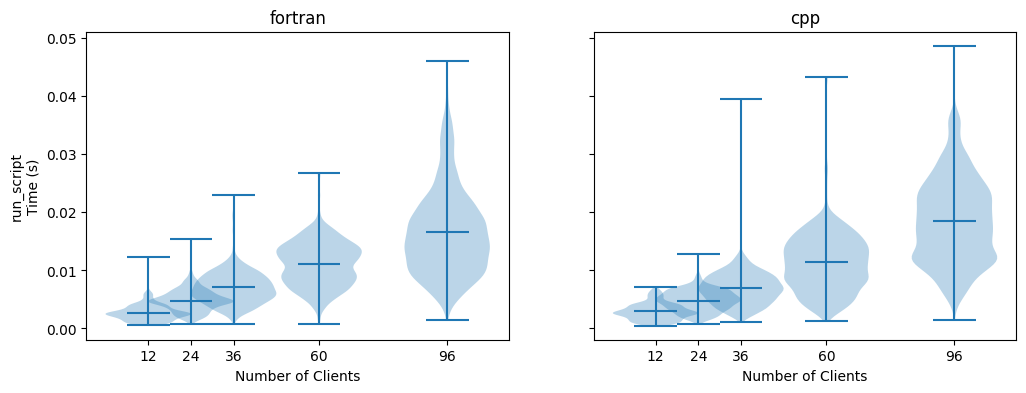

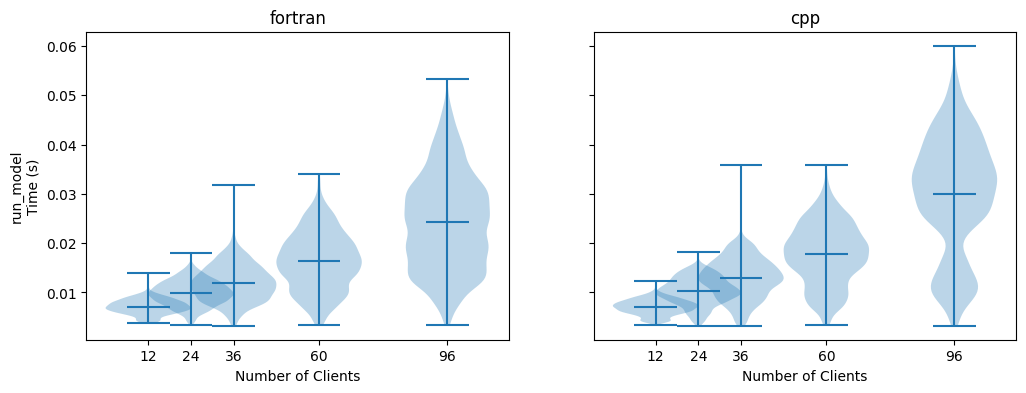

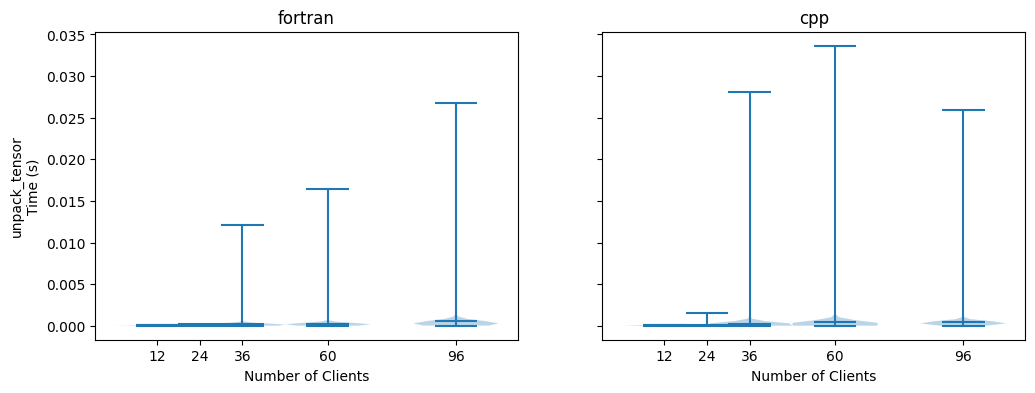

In [5]:
violin_opts = dict(        
    showmeans = True,
    showextrema = True,        
)

plt.style.use('default')

ordered_client_total = sorted(df['client_total'].unique())

function_names = ['put_tensor', 'run_script', 'run_model', 'unpack_tensor']
languages = ['fortran', 'cpp']

for function_name in function_names:
    fig = plt.figure(figsize=[12,4])
    axs = fig.subplots(1,2,sharey=True)
    for i, language in enumerate(languages):
        language_df = df.groupby('language').get_group(language)
        function_df = language_df.groupby('function').get_group(function_name)[ ['client_total','time'] ]

        data = [function_df.groupby('client_total').get_group(client)['time'] for client in ordered_client_total]
        pos = [int(client) for client in ordered_client_total]
        axs[i].violinplot(data, pos, **violin_opts, widths=24)
        axs[i].set_xlabel('Number of Clients')
        axs[i].set_title(language)
        axs[i].set_xticks(pos)
    axs[0].set_ylabel(f'{function_name}\nTime (s)')
# plt.box(put_tensor_df['client_total'], put_tensor_df['time'])

